In [143]:
import pandas as pd

#Data Loader

patent_intensity_df = pd.read_csv('Patent_Intensity.csv')
patent_intensity_df.head()


macro_variables_df = pd.read_csv('MacroVars.csv')
macro_variables_df = pd.read_csv('MacroVars.csv')
macro_variables_df.head()

macro_variables_df.drop(columns=['LFood', 'LClothShoes','HouseFurnEquip'], inplace=True)
macro_variables_df


macro_variables_df['Date'] = pd.to_datetime(macro_variables_df['Date'], format='%Y-%m')
macro_variables_df.head()


patent_intensity_df['Data Date'] = pd.to_datetime(patent_intensity_df['Data Date'], format='%y-%b')
patent_intensity_df.rename(columns={'Data Date': 'Date'}, inplace=True)
patent_intensity_df.head()



Combined_Df = pd.merge(patent_intensity_df, macro_variables_df, on='Date')
Combined_Df.head()
Combined_Df.set_index('Date', inplace=True)
Combined_Df.tail()
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime


RISKY_ASSET = 'AAPL' #INPUT STOCK HERE
START_DATE = '2012-12-31'
END_DATE = '2020-12-31'

#patent data does not exist for 2017
# momentum factor
df_mom = web.DataReader('F-F_Momentum_Factor', 'famafrench', 
                        start=START_DATE)[0]
df_mom.index = df_mom.index.format()

# five factors
df_five_factor = web.DataReader('F-F_Research_Data_5_Factors_2x3', 
                                'famafrench', 
                                start=START_DATE)[0]
df_five_factor.index = df_five_factor.index.format()
df_five_factor
asset_df = yf.download(RISKY_ASSET, start=START_DATE, end=END_DATE, 
                       #auto_adjust=True
                       progress=False)
y = asset_df['Adj Close'].resample('M') \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.strftime('%Y-%m')
y.name = 'return'


# join all datasets on the index
five_factor_data = df_five_factor.join(y)

# rename columns
five_factor_data.columns = ['mkt', 'smb', 'hml', 'rmw', 'cma', 
                            'rf', 'rtn']

# divide everything (except returns) by 100
five_factor_data.loc[:, five_factor_data.columns != 'rtn'] /= 100

# select period of interest
five_factor_data = five_factor_data.loc[START_DATE:END_DATE]

# calculate excess returns
five_factor_data['excess_rtn'] = five_factor_data.rtn - five_factor_data.rf

five_factor_data.tail()

five_factor_data.index = pd.to_datetime(five_factor_data.index, format='%Y-%m')
five_factor_data.head()
merged_df = pd.merge(Combined_Df, five_factor_data, left_index=True, right_index=True)
merged_df.head()


C:\Users\clint\AppData\Local\Temp\ipykernel_18116\2541112523.py:46: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_mom = web.DataReader('F-F_Momentum_Factor', 'famafrench',
C:\Users\clint\AppData\Local\Temp\ipykernel_18116\2541112523.py:46: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_mom = web.DataReader('F-F_Momentum_Factor', 'famafrench',
C:\Users\clint\AppData\Local\Temp\ipykernel_18116\2541112523.py:51: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_five_factor = web.DataReader('F-F_Research_Data_5_Factors_2x3',
C:\U

,Patent Intensity,GDP,CPI,Unemployment,Wages,BOP,CS,II,Rate,mkt,smb,hml,rmw,cma,rf,rtn,excess_rtn
2013-02-01,0.004285,3.681685,14.763859,-4.199767,0.487903,13.465117,4.617450,-56.536606,2.904197,0.0129,-0.0025,0.0011,-0.0067,0.0052,0.0,-0.025286,-0.025286
2013-03-01,0.004285,4.254620,1.973621,47.226706,6.512715,13.315896,4.599754,-59.157881,-0.830815,0.0403,0.0085,-0.0019,0.0014,0.0138,0.0,0.002854,0.002854
2013-04-01,0.004285,2.156549,-1.935423,-11.949708,5.965968,13.169941,4.582192,-62.004555,-3.403258,0.0155,-0.0225,0.0045,0.0027,0.0037,0.0,0.000271,0.000271
2013-05-01,0.004950,3.344113,2.973763,-24.433307,-10.098208,-33.017949,4.855700,583.953091,3.276578,0.0280,0.0206,0.0263,-0.0197,-0.0087,0.0,0.022419,0.022419
2013-06-01,0.004950,-4.256976,0.000000,30.833758,-8.853513,-33.939046,4.836135,424.235434,0.478039,-0.0120,0.0157,0.0003,-0.0038,0.0000,0.0,-0.118293,-0.118293


In [144]:

excess_rtn_df=merged_df.iloc[:, -1]
merged_df.rename(columns={'Patent Intensity': 'Patent_Intensity'}, inplace=True)

merged_df.head()
#Normalizer
for x in range(0, len(merged_df.columns)-1):
    merged_df.iloc[:, x] = (merged_df.iloc[:, x] - merged_df.iloc[:, x].mean()) / merged_df.iloc[:, x].std()

import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

Independent_df=merged_df.iloc[:, :-1]
Independent_df.head()

# Define the independent variables
independent_vars = Independent_df.columns.tolist()

# Define the dependent variable
dependent_var = 'excess_rtn'

# Create the OLS model
model = smf.ols(formula=f'{dependent_var} ~ {" + ".join(independent_vars)}', data=merged_df).fit()
coefficients = model.params
coefficients

df = coefficients.to_frame()
df = df.T
df = df.iloc[1:]
df

for x in range(0,len(merged_df)-24):
    model = smf.ols(formula=f'{dependent_var} ~ {" + ".join(independent_vars)}', data=merged_df[x:x+23]).fit()
    coefficients = model.params
    Current_df = coefficients.to_frame() 
    Current_df = Current_df.T
    df = pd.concat([df, Current_df])


df.head()

merged_df = merged_df.iloc[24:]
df.index=merged_df.index
df.head()

df['predicted_rtn'] = df.sum(axis=1)
df['excess_rtn'] = merged_df['excess_rtn']
# beta values found

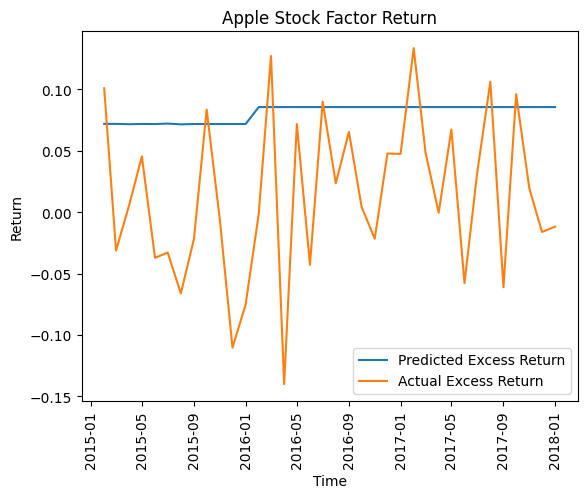

In [145]:
import matplotlib.pyplot as plt

# Plot the 'predicted_rtn' column against the 'excess_rtn' column over time
plt.plot(df.index, df['predicted_rtn'], label='Predicted Excess Return')
plt.plot(df.index, df['excess_rtn'], label='Actual Excess Return')
plt.xlabel('Time')
plt.ylabel('Return')
plt.xticks(rotation='vertical')
plt.title('Apple Stock Factor Return')
plt.legend()
plt.show()

In [146]:
# Change the date index to the format '2021-06'
df.index = df.index.strftime('%Y-%m')
df.head()

import numpy as np
import matplotlib.pyplot as plt
time=len(df)

# List all column names except the last two
column_names = df.columns[:-2].tolist()

categories = df.columns[:-2].tolist()
time_periods = df.index[:time].tolist()


df.iloc[:, 0]
data = np.array([df.iloc[:, 0].tolist()[:time]])   
for x in range(1,len(df.columns)-2):
    data = np.append(data, [df.iloc[:, x].tolist()[:time]], axis=0)


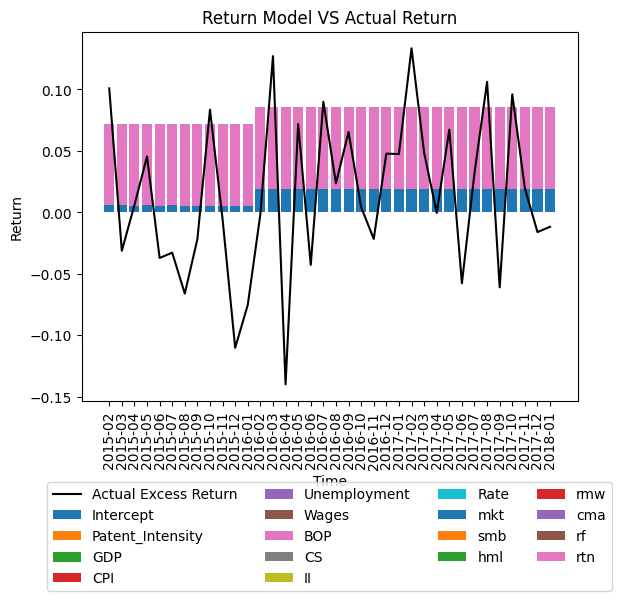

In [147]:

# Create stacked bar chart
fig, ax = plt.subplots()

# Plotting each category's bar
bottom = np.zeros(len(time_periods))
for i, category in enumerate(categories):
    ax.bar(time_periods, data[i], bottom=bottom, label=category)
    bottom += data[i]

# Customize the plot
ax.set_xlabel('Time')
ax.set_ylabel('Return')
ax.set_title('Return Model VS Actual Return')
ax.legend()

# Calculate trend line
x = np.arange(len(time_periods))
y=df['excess_rtn'].tolist()[:time]

# Plot the trend line
ax.plot(x, y, color='black', label='Actual Excess Return')
ax.legend()

# Set the legend below the graph
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)

# Set the x-axis tick labels to display horizontally
plt.xticks(rotation=90)
plt.xticks(fontsize=10)


# Display the chart
plt.show()
